# Homework 3 - Recharge
## Dave Murray - 2/24/20

### Assignment - 

Build a steady state box model. The model should have 25x25 cells, each 100 m in x and in y. There is one layer, 10 m thick. The medium is homogeneous with K = 1.0 m/day in x and y and 0.1 m/day in z. The porosity is 0.35, specific yield is 0.3, and storage coefficient is 0.001. The right boundary is zero flux, representing a closed basin. The left boundary is a constant head of 7 m relative to the datum, which is located at the bottom of the domain. Build two models.

**Part 1:**

First build a model with a uniform recharge at a rate of 5E-6 m/d over the entire domain (as defined for self check assignment 3).

Second, change the model so that recharge occurs only over the rightmost 20% of the domain; it is zero elsewhere. Adjust the recharge such that the total inflow into the second model is identical to that into the first model. (Hint: use the mass balance and adjust the recharge rate to match the first model!) For both models apply particles to every grid cell in the domain and track using forward tracking.

### Imports 

In [213]:
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

modelname = "RechargeModel"
moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel', '.nam']
    for ext in file_extensions:
        os.remove(modelname + ext)

In [214]:
nrow = 25 #number of rows
ncol = 25 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x diretion 
dy= 100 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 10.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

In [215]:
#Define cell activity (IBOUND)
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#set constand head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#Define Starting Heads
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 7    #replace first (left) col with desired head value

#print("starting head values: \n", H_init)

#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)


#LAYER Package File
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

#assigns horiz  and vertical Ks and saves cell-by-cell budget data
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

#print("oc stress period data: \n", spd)

oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

pcg = flopy.modflow.ModflowPcg(model=m)

### Recharge and discharge

In [216]:
#uniform recharge everywhere 
# rech_uniform = 5e-6                             #define uniform recharge flux (m/day)
# rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
# rech_zone=rech_zone+5e-6
# rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=130)     #create rch object

#Recharge on 1/3 of the domain 
rech_zone = np.zeros((nrow,ncol))                            #define an array of zeros of dim (nrow,ncol)
rech_zone[:,20:25] = 2.4e-5                                    #set recharge in rightmost 5 columns
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone)     #create rch object

#WEll
pumping_rate = -21 #in m^3/d, negative for pumping/positive for injection
well_loc=(0,12,12)
well_1 = [i for i in well_loc] + [pumping_rate]
print("Well 1 [layer, row, column, flux]: \n", well_1)

wel_spd = {0: [well_1]}
print("Well Stress Period Data: \n", wel_spd)

#Create flopy wel object 
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

Well 1 [layer, row, column, flux]: 
 [0, 12, 12, -21]
Well Stress Period Data: 
 {0: [[0, 12, 12, -21]]}


In [217]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')
    
    
#print(type(m))

FloPy is using the following  executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: RechargeModel.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/02/26 21:36:33

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/02/26 21:36:33
 Elapsed run time:  0.030 Seconds

  Normal termination of simulation


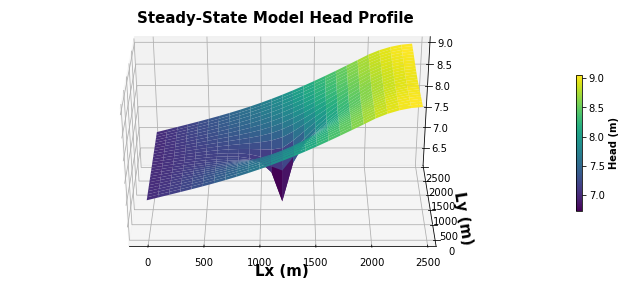

In [218]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])  

#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=25).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
ax.view_init(30,270)
#plt.show(surf)
plt.savefig('BoxModel_Surface1.png')

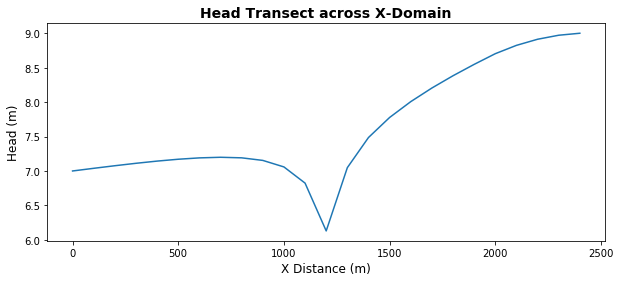

In [219]:
#plot head head transect
plt.figure(figsize = (10,4))
x = np.arange(0,Lx,dx)
#x2 = np.arange(0,Lx,4)
#plt.plot(x,np.flipud(head2[0])[int(nrow/2)][:])
plt.plot(x,np.flipud(head[0])[int(nrow/2)][:])
plt.title('Head Transect across X-Domain',fontweight = 'bold', fontsize = 14)
plt.xlabel('X Distance (m)',fontsize = 12)
plt.ylabel('Head (m)',fontsize = 12)
plt.show()


### Particle Tracker 

In [220]:
moddirmp="C:/WRDAPP/modpath_7_2_001/bin/mpath7.exe"

# create basic forward tracking modpath simulation
mpname=os.path.join(modelname + '_mp')
#print(mpname)

#Approach 1 for adding particles 
# This way you define a set of grid cells you want particles added to (plocs)
# Then specify the placement within each grid cell using the localx, localy and locaz parameters

#first make a list of the cells you want to add where cells are specified by ther (layer, row, column)
#plocs = []
#for idx in range(nrow):
#    plocs.append((0, idx, 0))
##print(plocs)

#part1 = flopy.modpath.ParticleData(plocs, drape=1, structured=True,localx=0.5, localy=0.5, localz=0.99 )
#pg1 = flopy.modpath.ParticleGroup(particlegroupname='PG2', particledata=part1,filename='ex01a.pg2.sloc')


#Approach 2 for inserting particles using regions and cell divisons
#Set the rante of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
locsb = [[0, 0, 0, 0, nrow - 1, ncol-1]]
#set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1)
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg2 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg2]

defaultiface = {'RECHARGE': 6, 'ET': 6} #top of grid cell

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                 trackingdirection='forward',
                                 weaksinkoption='stop_at',
                                 weaksourceoption='stop_at',
                                 budgetoutputoption='summary',
                                 stoptimeoption='extend', 
                                 particlegroups= particlegroups)

###NOTE: This is how we inserted particles in class the .create funciton creates a default model 
#So  it is faster but gives you less  control over  parameters like  porosity.
#setup the modpath model starting particles just in the cells you listed and doing backward tracking

#mp = flopy.modpath.Modpath7.create_mp7(modelname=mpname, trackdir='backward', flowmodel=m,  
#                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
#                                        exe_name=moddirmp, nodes=nodesr)

#setup the modpath model starting particles everywhere and doing forward tracking
#mp = flopy.modpath.Modpath7.create_mp7(modelname=mpname, trackdir='forward', flowmodel=m,  
#                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
#                                        exe_name=moddirmp)

mp.add_package(rch)
#write modpath datasets
mp.write_input()

#run modpath
mp.run_model()

mp.get_package_list()

FloPy is using the following  executable to run the model: C:/WRDAPP/modpath_7_2_001/bin/mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
       625 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


['MPBAS', 'MPSIM', 'RCH']

In [221]:
#load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

# #make a subset which is the partlces that end in the well 
# nodewell = m.dis.get_node([well_loc])
# print(nodewell)
pwell = p.get_destination_pathline_data(dest_cells=nodewell)
ewell= e.get_destination_endpoint_data(dest_cells=nodewell)
print(ewell.size)
# plocs = []
# for idx in range(nrow):
#    plocs.append((0, idx, 0))

# notwell = m.dis.get_node(plocs)
# print(notwell)

# enotwell = e.get_destination_endpoint_data(dest_cells=notwell)

251


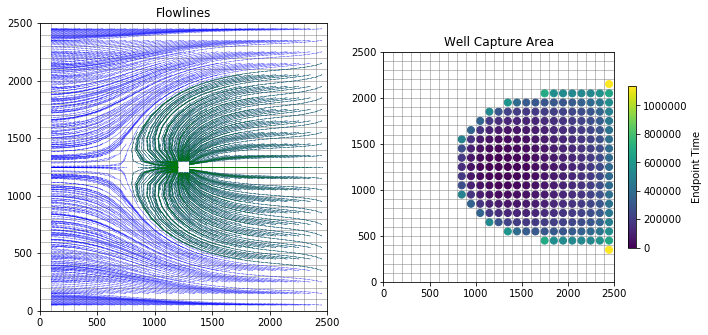

In [222]:
f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax = axes[0]
ax.set_aspect('equal')
ax.set_title('Flowlines')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell, layer='all', color='green', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
#mm.plot_endpoint(eall, direction='ending', colorbar=True, shrink=0.5);
#mm.plot_endpoint(eall, direction='starting')
#mm.ax.legend();

ax = axes[1]
ax.set_aspect('equal')
ax.set_title('Well Capture Area')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_endpoint(ewell, direction='starting', colorbar=True, shrink=0.5);
#mm.plot_endpoint(eall, direction='ending', colorbar=True, shrink=0.5);
mm.plot_grid(lw=0.5)
#mm.plot_pathline(prb, layer='all', color='green', lw=0.5, linestyle=':', label='captured by rivers')

plt.tight_layout();

In [223]:
#There are two ways to access a column of data: 
#1. 
#print('This is the first way of accessing a column')
#data_eall=eall.view(np.recarray)
#data_ewell=ewell.view(np.recarray)

#print(data_eall.particleid)

#2. 
#print('This is the second way of accessing a column')
#print(eall['particleid'])

#If you want to grab out one row of data (i.e. the complete start stop record for one particle)
# print('This is the way to access a row')
# print(data_eall[1])

#Now make a simple plot of particle starting x locaiton and ending y location 
# x=enotwell['x0']
# y=enotwell['time']/365
# x2=eall['x0']
# y2=eall['time']/365
# plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='')
# plt.plot(x2,y2,marker='o', color='blue', markersize=4, linestyle='')
# plt.title('Scatter plot pythonspot.com')
# plt.xlabel('Sarting X location [m]')
# plt.ylabel('Time [years]')
# plt.title("Travel times for Particles Not Captured")
# plt.legend(['With Well','No Well'])
# plt.savefig('Travel_Times_Well.png')